## Importing required libraries

In [140]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from scipy.stats import kruskal
import seaborn as sb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from prophet import Prophet
from matplotlib import pyplot
from prophet.utilities import regressor_coefficients

In [141]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Loading cleaned dataset

In [142]:
df=pd.read_csv("imputed_cleaned_highly_correlated_removed_df.csv")
df=df.drop(["Unnamed: 0"],axis=1)

In [143]:
# Dropping the feature that showed negative values in the later years

df=df.drop(["Population growth (annual %)"],axis=1)
df.head()

,Date,"Population ages 35-39, male (% of male population)","Population ages 30-34, male (% of male population)","Population ages 30-34, female (% of female population)","Population ages 25-29, male (% of male population)","Population ages 20-24, male (% of male population)","Population ages 20-24, female (% of female population)","Population ages 15-64, male (% of male population)","Population ages 05-09, female (% of female population)","Survival to age 65, male (% of cohort)",Domestic general government health expenditure (% of current health expenditure),People using at least basic sanitation services (% of population),"Immunization, measles (% of children ages 12-23 months)","Immunization, DPT (% of children ages 12-23 months)",People using at least basic drinking water services (% of population),Country
0,31/12/2000,10.580224,10.970504,9.675833,11.124948,9.914067,9.630265,71.751589,11.584550,80.639037,71.090942,99.927678,98.0,97.0,99.910081,Bahrain
1,31/12/2001,10.523844,11.257000,9.751845,11.371230,9.581943,9.695009,72.227151,11.445216,81.744027,71.686089,99.933661,98.0,99.0,99.917519,Bahrain
2,31/12/2002,10.564876,11.625352,9.856252,11.507597,9.144013,9.702925,72.721201,11.290628,81.960392,71.251640,99.939643,99.0,98.0,99.924957,Bahrain
3,31/12/2003,10.604646,11.901189,9.866896,11.566314,9.135526,9.741478,73.620983,10.985535,82.677625,65.968887,99.945626,99.0,97.0,99.932395,Bahrain
4,31/12/2004,10.546060,11.983681,9.706156,11.770021,10.018271,9.963415,75.152958,10.445477,83.000012,67.336205,99.951608,99.0,98.0,99.939833,Bahrain


In [144]:
# df_original = df_log_scaled.apply(lambda x: np.expm1(x) if x.name not in columns_to_exclude else x)
# df_original

In [145]:
countries=df["Country"].unique().tolist()
#countries
for i in range(len(countries)):
    country=countries[i]
    dataset=df.query("Country==@country")
    dataset=dataset.rename(columns={"index":"Date"})
    dataset=dataset.reset_index()
    dataset=dataset.drop(["Country","index"],axis=1)
    indicators=dataset.columns[1:].tolist()

## Getting the indicator code names

In [146]:
old_df=pd.read_csv("API_8_DS2_en_csv_v2_5458541.csv")
old_df=old_df[["Indicator Name","Indicator Code"]]
old_df=old_df.drop_duplicates()

indicator_code=[]
indicator_name=[]
# for i in range(len(indicators)):
#     if indicators[i] in old_df["Indicator Name"].tolist():
#         print(old_df["Indicator Code"][i])
#         indicator_code.append(old_df["Indicator Code"][i])
        
        
all_indicators=old_df["Indicator Name"].tolist()
all_codes=old_df["Indicator Code"].tolist()
for i in range(len(indicators)):
    for j in range(len(all_indicators)):
        if indicators[i]==all_indicators[j]:
            #print(features[i],all_codes[j])
            print(all_codes[j])
            indicator_code.append(all_codes[j])
            indicator_name.append(all_indicators[j])

SP.POP.3539.MA.5Y
SP.POP.3034.MA.5Y
SP.POP.3034.FE.5Y
SP.POP.2529.MA.5Y
SP.POP.2024.MA.5Y
SP.POP.2024.FE.5Y
SP.POP.1564.MA.ZS
SP.POP.0509.FE.5Y
SP.DYN.TO65.MA.ZS
SH.XPD.GHED.CH.ZS
SH.STA.BASS.ZS
SH.IMM.MEAS
SH.IMM.IDPT
SH.H2O.BASW.ZS


In [147]:
indic_df = pd.DataFrame({'Name': indicator_name, 'Code': indicator_code})
indic_df

,Name,Code
0,"Population ages 35-39, male (% of male populat...",SP.POP.3539.MA.5Y
1,"Population ages 30-34, male (% of male populat...",SP.POP.3034.MA.5Y
2,"Population ages 30-34, female (% of female pop...",SP.POP.3034.FE.5Y
3,"Population ages 25-29, male (% of male populat...",SP.POP.2529.MA.5Y
4,"Population ages 20-24, male (% of male populat...",SP.POP.2024.MA.5Y
5,"Population ages 20-24, female (% of female pop...",SP.POP.2024.FE.5Y
6,"Population ages 15-64, male (% of male populat...",SP.POP.1564.MA.ZS
7,"Population ages 05-09, female (% of female pop...",SP.POP.0509.FE.5Y
8,"Survival to age 65, male (% of cohort)",SP.DYN.TO65.MA.ZS
9,Domestic general government health expenditure...,SH.XPD.GHED.CH.ZS


In [149]:
indic_df.to_csv("indic_df.csv")

## Plotting the data distribution of each indicator for each country

Bahrain
Kuwait
Oman
Qatar
SaudiArabia


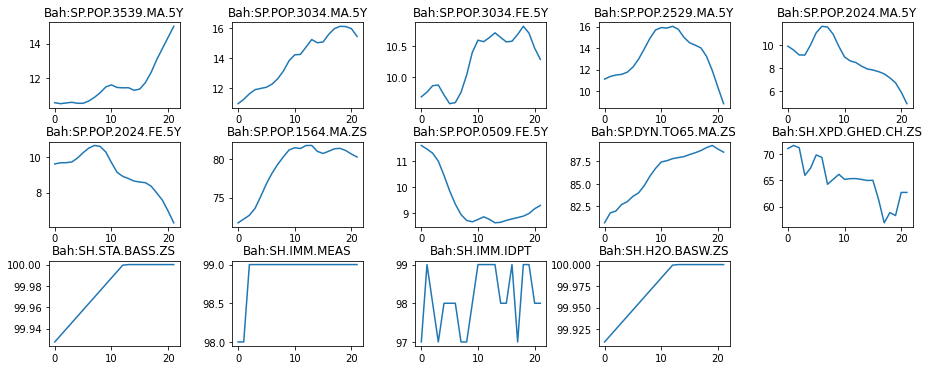

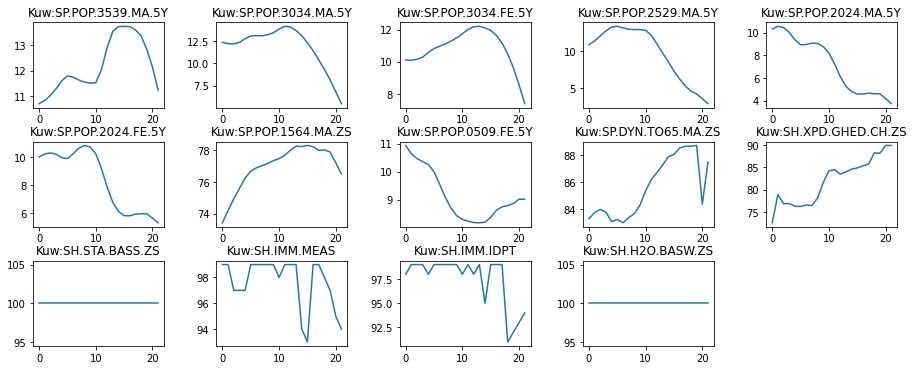

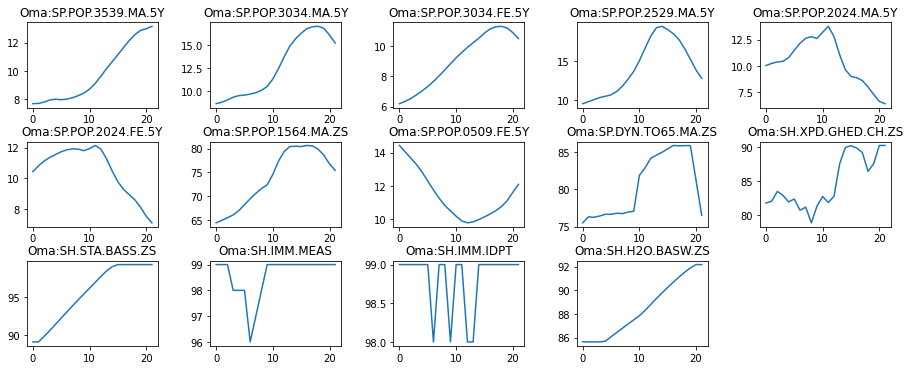

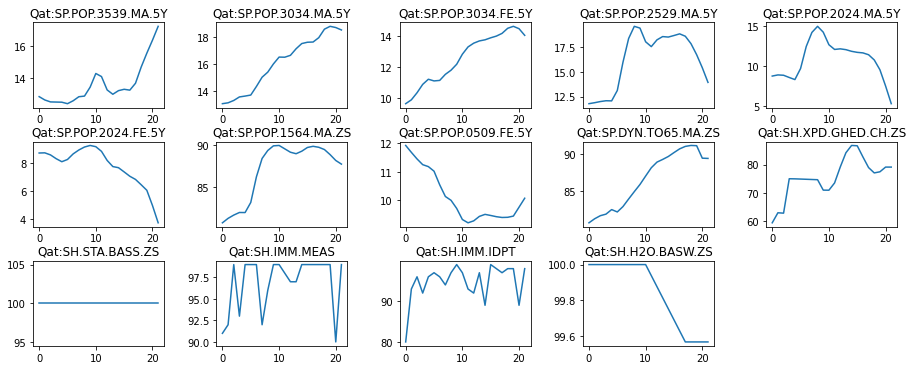

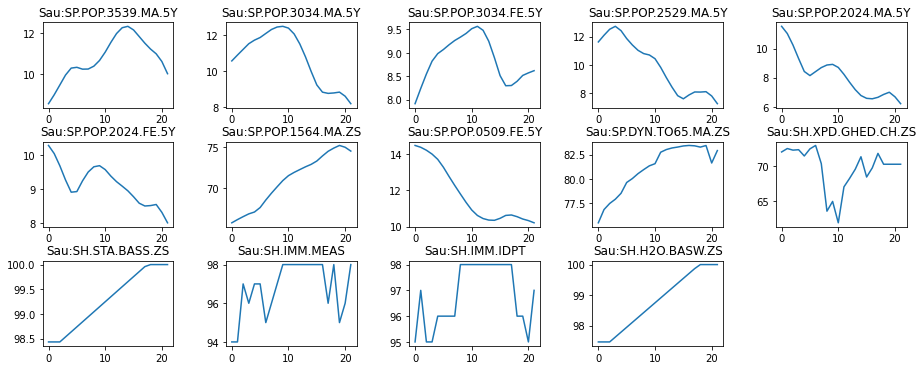

In [150]:
countries=df["Country"].unique().tolist()
#countries
for i in range(len(countries)):
    country=countries[i]
    dataset=df.query("Country==@country")
    dataset=dataset.rename(columns={"index":"Date"})
    dataset=dataset.reset_index()
    dataset=dataset.drop(["Country","index"],axis=1)
    #dataset=dataset.fillna(dataset.mean())
    #display(dataset)
    
    indicators=dataset.columns[1:].tolist()
    print(color.BOLD+countries[i]+color.END)

    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(left=0.1,
                    bottom=0.25,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    
    #for each indicators
    for j in range(len(indicators)):
        indicator=indicators[j]
        ax = plt.subplot(5, 5, j + 1)
        title_ax=str(countries[i][0:3])+':'+str(indicator_code[j])
        ax.title.set_text(title_ax)
        #ax.set_figheight(15)
        #ax.set_figwidth(20)
        dataset[indicator].plot(ax=ax)

In [151]:
indicators, indicator_code

(['Population ages 35-39, male (% of male population)',
  'Population ages 30-34, male (% of male population)',
  'Population ages 30-34, female (% of female population)',
  'Population ages 25-29, male (% of male population)',
  'Population ages 20-24, male (% of male population)',
  'Population ages 20-24, female (% of female population)',
  'Population ages 15-64, male (% of male population)',
  'Population ages 05-09, female (% of female population)',
  'Survival to age 65, male (% of cohort)',
  'Domestic general government health expenditure (% of current health expenditure)',
  'People using at least basic sanitation services (% of population)',
  'Immunization, measles (% of children ages 12-23 months)',
  'Immunization, DPT (% of children ages 12-23 months)',
  'People using at least basic drinking water services (% of population)'],
 ['SP.POP.3539.MA.5Y',
  'SP.POP.3034.MA.5Y',
  'SP.POP.3034.FE.5Y',
  'SP.POP.2529.MA.5Y',
  'SP.POP.2024.MA.5Y',
  'SP.POP.2024.FE.5Y',
  'SP.P

In [152]:
def get_country_specific_dataset(df, country):
    dataset=df.query("Country==@country")
    dataset=dataset.rename(columns={"index":"Date"})
    dataset=dataset.reset_index()
    dataset=dataset.drop(["Country","index"],axis=1)
    indicators=dataset.columns[1:].tolist()
    print(color.BOLD+countries[k]+color.END)
    #making date as the index of the dataset
    dataset=dataset.dropna(axis=1, how='all')
    dataset = dataset.set_index(['Date'])
    return dataset


def get_country_specific_dataset_2(df, country):
    dataset=df.query("Country==@country")
    dataset=dataset.rename(columns={"index":"Date"})
    dataset=dataset.reset_index()
    dataset=dataset.drop(["Country"],axis=1)
    indicators=dataset.columns[1:].tolist()
    print(color.BOLD+countries[k]+color.END)
    #making date as the index of the dataset
    dataset=dataset.dropna(axis=1, how='all')
    dataset = dataset.set_index(['Date'])
    return dataset

In [153]:
def get_indicator_code(old_df,train_df):
    name_df=old_df
    all_indicators=old_df["Indicator Name"].tolist()
    all_codes=old_df["Indicator Code"].tolist()
    indicators_in_the_country=train_df.columns.tolist()
    indicator_code_in_the_country=[]
    for i in range(len(indicators_in_the_country)):
        for j in range(len(all_indicators)):
            if indicators_in_the_country[i]==all_indicators[j]:
                indicator_code_in_the_country.append(all_codes[j])
    return indicator_code_in_the_country

In [154]:
# y_true: true values of the dependent variable
# y_pred: predicted values of the dependent variable
# n: number of observations
# k: number of predictors
def adjusted_r2_score(y_true, y_pred, n, k):
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    return adjusted_r2

In [155]:
indicators_list=df.drop(["Date","Country"],axis=1).columns.tolist()
indicators_list

['Population ages 35-39, male (% of male population)',
 'Population ages 30-34, male (% of male population)',
 'Population ages 30-34, female (% of female population)',
 'Population ages 25-29, male (% of male population)',
 'Population ages 20-24, male (% of male population)',
 'Population ages 20-24, female (% of female population)',
 'Population ages 15-64, male (% of male population)',
 'Population ages 05-09, female (% of female population)',
 'Survival to age 65, male (% of cohort)',
 'Domestic general government health expenditure (% of current health expenditure)',
 'People using at least basic sanitation services (% of population)',
 'Immunization, measles (% of children ages 12-23 months)',
 'Immunization, DPT (% of children ages 12-23 months)',
 'People using at least basic drinking water services (% of population)']

## Run it for all the countries together

02:31:19 - cmdstanpy - INFO - Chain [1] start processing
02:31:19 - cmdstanpy - INFO - Chain [1] done processing
02:31:19 - cmdstanpy - INFO - Chain [1] start processing
02:31:19 - cmdstanpy - INFO - Chain [1] done processing
02:31:19 - cmdstanpy - INFO - Chain [1] start processing


Country: Bahrain
Bahrain


02:31:19 - cmdstanpy - INFO - Chain [1] done processing
02:31:19 - cmdstanpy - INFO - Chain [1] start processing
02:31:19 - cmdstanpy - INFO - Chain [1] done processing
02:31:19 - cmdstanpy - INFO - Chain [1] start processing
02:31:19 - cmdstanpy - INFO - Chain [1] done processing
02:31:19 - cmdstanpy - INFO - Chain [1] start processing
02:31:19 - cmdstanpy - INFO - Chain [1] done processing
02:31:19 - cmdstanpy - INFO - Chain [1] start processing
02:31:19 - cmdstanpy - INFO - Chain [1] done processing
02:31:19 - cmdstanpy - INFO - Chain [1] start processing
02:31:19 - cmdstanpy - INFO - Chain [1] done processing
02:31:19 - cmdstanpy - INFO - Chain [1] start processing
02:31:19 - cmdstanpy - INFO - Chain [1] done processing
02:31:19 - cmdstanpy - INFO - Chain [1] start processing
02:31:19 - cmdstanpy - INFO - Chain [1] done processing
02:31:20 - cmdstanpy - INFO - Chain [1] start processing
02:31:25 - cmdstanpy - INFO - Chain [1] done processing
02:31:25 - cmdstanpy - INFO - Chain [1] 

Bahrain
Indicator: Population ages 35-39, male (% of male population)
RMSE: 0.018678907013764696
MAPE: 0.0008487939040700371
R-squared: 0.9997779485945804
Adjusted R-squared: 0.9997668460243094

Bahrain
Indicator: Population ages 30-34, male (% of male population)
RMSE: 0.20466560331533656
MAPE: 0.011930485141640445
R-squared: 0.9856089006577216
Adjusted R-squared: 0.9848893456906076

Bahrain
Indicator: Population ages 30-34, female (% of female population)
RMSE: 0.08596988646485866
MAPE: 0.006844194335593231
R-squared: 0.957655676594126
Adjusted R-squared: 0.9555384604238323

Bahrain
Indicator: Population ages 25-29, male (% of male population)
RMSE: 0.458621607828117
MAPE: 0.030749252629991418
R-squared: 0.9416896898197673
Adjusted R-squared: 0.9387741743107557

Bahrain
Indicator: Population ages 20-24, male (% of male population)
RMSE: 0.5457426072475907
MAPE: 0.05303361058051477
R-squared: 0.8817353996926774
Adjusted R-squared: 0.8758221696773113

Bahrain
Indicator: Population ages

02:31:31 - cmdstanpy - INFO - Chain [1] start processing


Bahrain
Indicator: Immunization, DPT (% of children ages 12-23 months)
RMSE: 0.46170363601383313
MAPE: 0.003580133666494074
R-squared: 0.19505855043127274
Adjusted R-squared: 0.15481147795283634

Bahrain
Indicator: People using at least basic drinking water services (% of population)
RMSE: 6.761344273177387e-05
MAPE: 5.48410298825013e-07
R-squared: 0.9999952042659831
Adjusted R-squared: 0.9999949644792823

Country: Kuwait
Kuwait


02:31:32 - cmdstanpy - INFO - Chain [1] done processing
02:31:32 - cmdstanpy - INFO - Chain [1] start processing
02:31:32 - cmdstanpy - INFO - Chain [1] done processing
02:31:32 - cmdstanpy - INFO - Chain [1] start processing
02:31:32 - cmdstanpy - INFO - Chain [1] done processing
02:31:32 - cmdstanpy - INFO - Chain [1] start processing
02:31:32 - cmdstanpy - INFO - Chain [1] done processing
02:31:32 - cmdstanpy - INFO - Chain [1] start processing
02:31:32 - cmdstanpy - INFO - Chain [1] done processing
02:31:32 - cmdstanpy - INFO - Chain [1] start processing
02:31:32 - cmdstanpy - INFO - Chain [1] done processing
02:31:32 - cmdstanpy - INFO - Chain [1] start processing
02:31:32 - cmdstanpy - INFO - Chain [1] done processing
02:31:32 - cmdstanpy - INFO - Chain [1] start processing
02:31:32 - cmdstanpy - INFO - Chain [1] done processing
02:31:32 - cmdstanpy - INFO - Chain [1] start processing
02:31:32 - cmdstanpy - INFO - Chain [1] done processing
02:31:32 - cmdstanpy - INFO - Chain [1] 

Kuwait
Indicator: Population ages 35-39, male (% of male population)
RMSE: 0.17476532536204004
MAPE: 0.011534650532108209
R-squared: 0.9686596270870114
Adjusted R-squared: 0.9670926084413619

Kuwait
Indicator: Population ages 30-34, male (% of male population)
RMSE: 0.22475550124367102
MAPE: 0.01817494746983614
R-squared: 0.9907018861096776
Adjusted R-squared: 0.9902369804151615

Kuwait
Indicator: Population ages 30-34, female (% of female population)
RMSE: 0.17307620101894527
MAPE: 0.012520446803361295
R-squared: 0.9781334129526332
Adjusted R-squared: 0.9770400836002648

Kuwait
Indicator: Population ages 25-29, male (% of male population)
RMSE: 2.3871389548737594
MAPE: 0.2072365065971338
R-squared: 0.5724939031687553
Adjusted R-squared: 0.551118598327193

Kuwait
Indicator: Population ages 20-24, male (% of male population)
RMSE: 0.6843410834903056
MAPE: 0.07334709710190616
R-squared: 0.918165249906142
Adjusted R-squared: 0.9140735124014491

Kuwait
Indicator: Population ages 20-24, fem

02:31:34 - cmdstanpy - INFO - Chain [1] start processing
02:31:34 - cmdstanpy - INFO - Chain [1] done processing


Kuwait
Indicator: Immunization, DPT (% of children ages 12-23 months)
RMSE: 1.4663693825301485
MAPE: 0.011431543070327371
R-squared: 0.47440156044990567
Adjusted R-squared: 0.44812163847240094

Kuwait
Indicator: People using at least basic drinking water services (% of population)
RMSE: 2.842170943040401e-14
MAPE: 2.842170943040401e-16
R-squared: -3.0
Adjusted R-squared: -3.2

Country: Oman
Oman


02:31:34 - cmdstanpy - INFO - Chain [1] start processing
02:31:34 - cmdstanpy - INFO - Chain [1] done processing
02:31:34 - cmdstanpy - INFO - Chain [1] start processing
02:31:34 - cmdstanpy - INFO - Chain [1] done processing
02:31:34 - cmdstanpy - INFO - Chain [1] start processing
02:31:34 - cmdstanpy - INFO - Chain [1] done processing
02:31:34 - cmdstanpy - INFO - Chain [1] start processing
02:31:34 - cmdstanpy - INFO - Chain [1] done processing
02:31:34 - cmdstanpy - INFO - Chain [1] start processing
02:31:34 - cmdstanpy - INFO - Chain [1] done processing
02:31:34 - cmdstanpy - INFO - Chain [1] start processing
02:31:34 - cmdstanpy - INFO - Chain [1] done processing
02:31:34 - cmdstanpy - INFO - Chain [1] start processing
02:31:34 - cmdstanpy - INFO - Chain [1] done processing
02:31:34 - cmdstanpy - INFO - Chain [1] start processing
02:31:35 - cmdstanpy - INFO - Chain [1] done processing
02:31:35 - cmdstanpy - INFO - Chain [1] start processing
02:31:35 - cmdstanpy - INFO - Chain [1]

Oman
Indicator: Population ages 35-39, male (% of male population)
RMSE: 0.07277196784253268
MAPE: 0.004789863854098813
R-squared: 0.9986303157771187
Adjusted R-squared: 0.9985618315659747

Oman
Indicator: Population ages 30-34, male (% of male population)
RMSE: 0.21004063663015898
MAPE: 0.011052064390983858
R-squared: 0.9955691274867334
Adjusted R-squared: 0.9953475838610701

Oman
Indicator: Population ages 30-34, female (% of female population)
RMSE: 0.09540012027613379
MAPE: 0.006381100086557678
R-squared: 0.9970983558980215
Adjusted R-squared: 0.9969532736929226

Oman
Indicator: Population ages 25-29, male (% of male population)
RMSE: 0.1112808052953202
MAPE: 0.00517018591824027
R-squared: 0.9989270773967238
Adjusted R-squared: 0.99887343126656

Oman
Indicator: Population ages 20-24, male (% of male population)
RMSE: 0.3857069259217761
MAPE: 0.027887788604658372
R-squared: 0.9626642003350128
Adjusted R-squared: 0.9607974103517634

Oman
Indicator: Population ages 20-24, female (% of

02:31:46 - cmdstanpy - INFO - Chain [1] start processing


Oman
Indicator: Immunization, DPT (% of children ages 12-23 months)
RMSE: 0.0007267104893117617
MAPE: 7.004482244390115e-06
R-squared: 0.999996450634893
Adjusted R-squared: 0.9999962731666376

Oman
Indicator: People using at least basic drinking water services (% of population)
RMSE: 0.04845108897243883
MAPE: 0.00027646485605407434
R-squared: 0.9995757866871328
Adjusted R-squared: 0.9995545760214894

Country: Qatar
Qatar


02:31:46 - cmdstanpy - INFO - Chain [1] done processing
02:31:46 - cmdstanpy - INFO - Chain [1] start processing
02:31:46 - cmdstanpy - INFO - Chain [1] done processing
02:31:46 - cmdstanpy - INFO - Chain [1] start processing
02:31:46 - cmdstanpy - INFO - Chain [1] done processing
02:31:46 - cmdstanpy - INFO - Chain [1] start processing
02:31:46 - cmdstanpy - INFO - Chain [1] done processing
02:31:46 - cmdstanpy - INFO - Chain [1] start processing
02:31:47 - cmdstanpy - INFO - Chain [1] done processing
02:31:47 - cmdstanpy - INFO - Chain [1] start processing
02:31:47 - cmdstanpy - INFO - Chain [1] done processing
02:31:47 - cmdstanpy - INFO - Chain [1] start processing
02:31:47 - cmdstanpy - INFO - Chain [1] done processing
02:31:47 - cmdstanpy - INFO - Chain [1] start processing
02:31:47 - cmdstanpy - INFO - Chain [1] done processing
02:31:47 - cmdstanpy - INFO - Chain [1] start processing
02:31:47 - cmdstanpy - INFO - Chain [1] done processing
02:31:47 - cmdstanpy - INFO - Chain [1] 

Qatar
Indicator: Population ages 35-39, male (% of male population)
RMSE: 0.06035302328296158
MAPE: 0.003376672661554485
R-squared: 0.9977941313785975
Adjusted R-squared: 0.9976838379475274

Qatar
Indicator: Population ages 30-34, male (% of male population)
RMSE: 0.1326109795387161
MAPE: 0.006184828280863772
R-squared: 0.9955819242233998
Adjusted R-squared: 0.9953610204345698

Qatar
Indicator: Population ages 30-34, female (% of female population)
RMSE: 0.1325606555147595
MAPE: 0.007559149317498778
R-squared: 0.9929823574026783
Adjusted R-squared: 0.9926314752728121

Qatar
Indicator: Population ages 25-29, male (% of male population)
RMSE: 1.0602759411145535
MAPE: 0.05464888288141644
R-squared: 0.7969899309689505
Adjusted R-squared: 0.7868394275173981

Qatar
Indicator: Population ages 20-24, male (% of male population)
RMSE: 2.343088222806553
MAPE: 0.19514400841972493
R-squared: -23.381077683263477
Adjusted R-squared: -24.60013156742665

Qatar
Indicator: Population ages 20-24, female 

02:31:49 - cmdstanpy - INFO - Chain [1] start processing


Qatar
Indicator: Immunization, measles (% of children ages 12-23 months)
RMSE: 2.1696510596539134
MAPE: 0.01674829993622693
R-squared: -0.1723104593685072
Adjusted R-squared: -0.2309259823369325

Qatar
Indicator: Immunization, DPT (% of children ages 12-23 months)
RMSE: 3.109292349779791
MAPE: 0.025739700995472344
R-squared: -0.2175971674644408
Adjusted R-squared: -0.27847702583766276

Qatar
Indicator: People using at least basic drinking water services (% of population)
RMSE: 0.0065782129409583555
MAPE: 2.8960815437638898e-05
R-squared: 0.9987055893799032
Adjusted R-squared: 0.9986408688488984

Country: SaudiArabia
SaudiArabia


02:31:49 - cmdstanpy - INFO - Chain [1] done processing
02:31:49 - cmdstanpy - INFO - Chain [1] start processing
02:31:49 - cmdstanpy - INFO - Chain [1] done processing
02:31:49 - cmdstanpy - INFO - Chain [1] start processing
02:31:49 - cmdstanpy - INFO - Chain [1] done processing
02:31:49 - cmdstanpy - INFO - Chain [1] start processing
02:31:49 - cmdstanpy - INFO - Chain [1] done processing
02:31:49 - cmdstanpy - INFO - Chain [1] start processing
02:31:49 - cmdstanpy - INFO - Chain [1] done processing
02:31:49 - cmdstanpy - INFO - Chain [1] start processing
02:31:49 - cmdstanpy - INFO - Chain [1] done processing
02:31:49 - cmdstanpy - INFO - Chain [1] start processing
02:31:49 - cmdstanpy - INFO - Chain [1] done processing
02:31:49 - cmdstanpy - INFO - Chain [1] start processing
02:31:50 - cmdstanpy - INFO - Chain [1] done processing
02:31:50 - cmdstanpy - INFO - Chain [1] start processing
02:31:50 - cmdstanpy - INFO - Chain [1] done processing
02:31:50 - cmdstanpy - INFO - Chain [1] 

SaudiArabia
Indicator: Population ages 35-39, male (% of male population)
RMSE: 0.04622052053759662
MAPE: 0.0029260089931278915
R-squared: 0.9979212802100883
Adjusted R-squared: 0.9978173442205928

SaudiArabia
Indicator: Population ages 30-34, male (% of male population)
RMSE: 0.06854189318234437
MAPE: 0.005402711963201272
R-squared: 0.9978054746302049
Adjusted R-squared: 0.9976957483617152

SaudiArabia
Indicator: Population ages 30-34, female (% of female population)
RMSE: 0.004490732859921202
MAPE: 0.00026080055839387427
R-squared: 0.9999098848947858
Adjusted R-squared: 0.9999053791395252

SaudiArabia
Indicator: Population ages 25-29, male (% of male population)
RMSE: 0.3422823174855142
MAPE: 0.02994756104669677
R-squared: 0.9637997973724367
Adjusted R-squared: 0.9619897872410585

SaudiArabia
Indicator: Population ages 20-24, male (% of male population)
RMSE: 0.5155731424871984
MAPE: 0.053049006778062985
R-squared: 0.8451567487870097
Adjusted R-squared: 0.8374145862263602

SaudiArabi

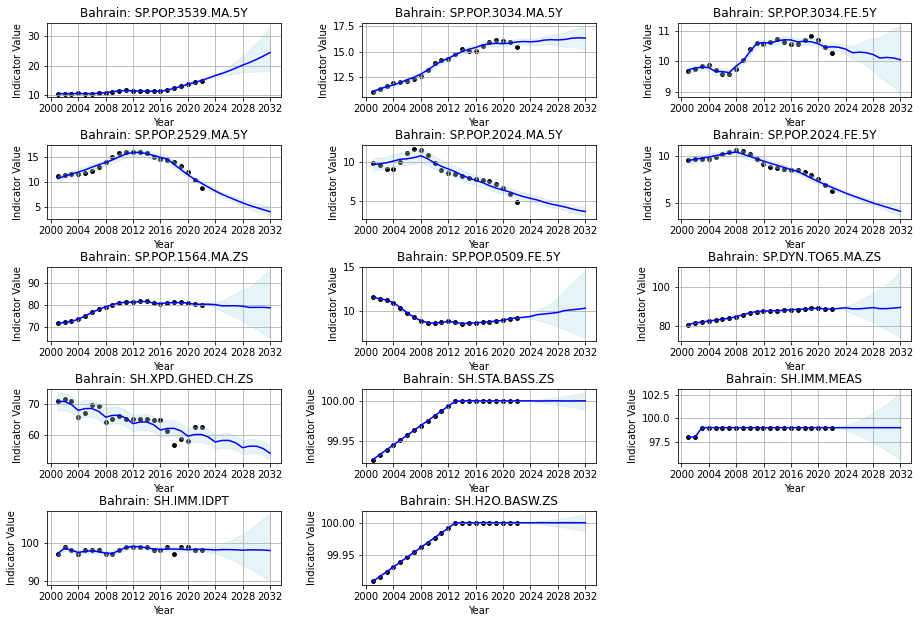

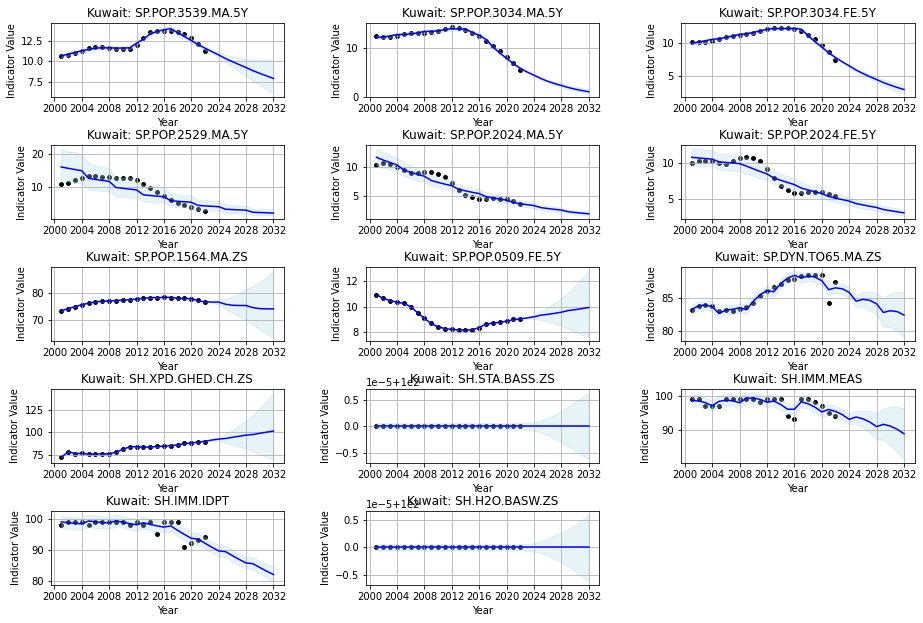

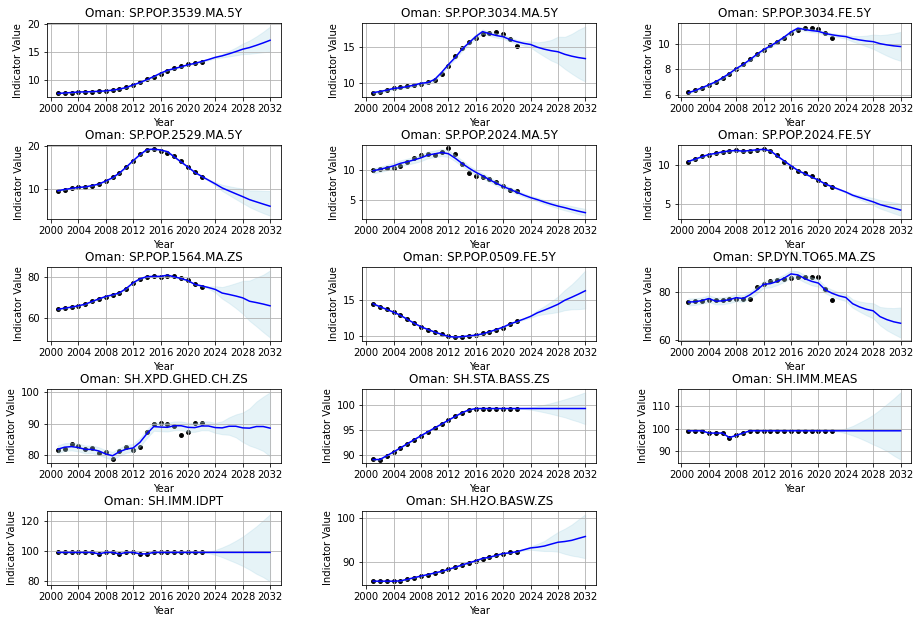

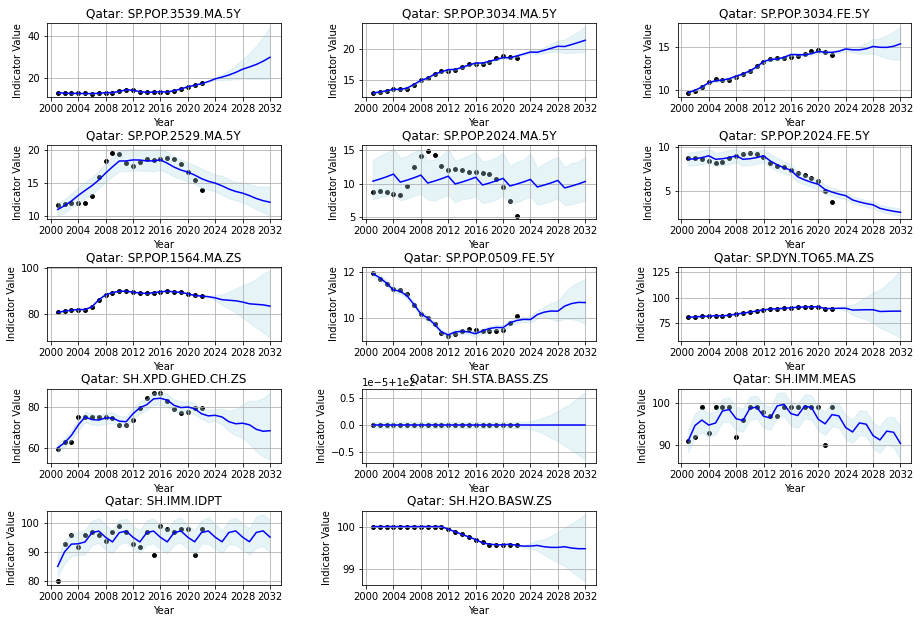

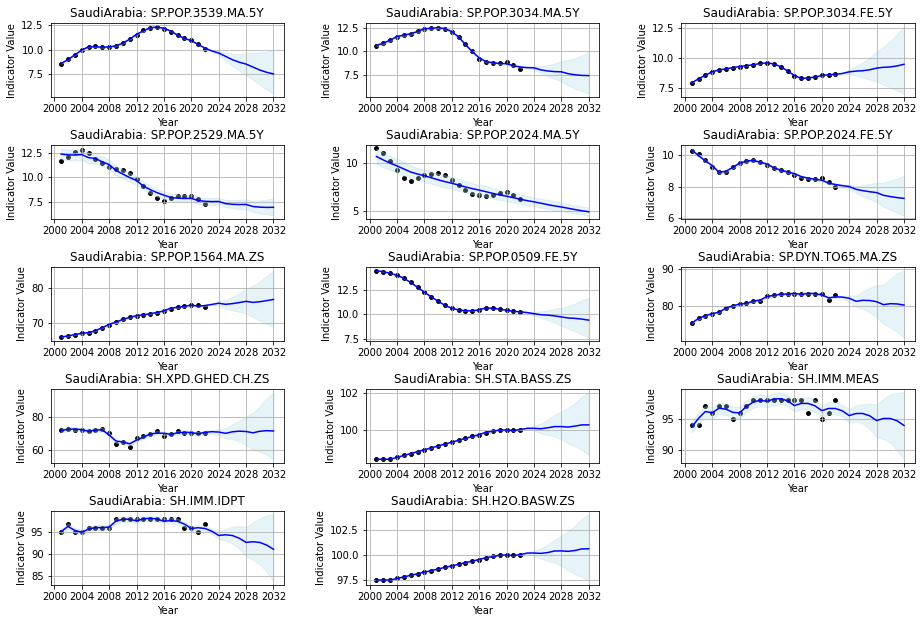

In [180]:
countries=df["Country"].unique().tolist()

for k in range(len(countries)):
#     if k>0:
#         break
    
    plt.figure(figsize=(15, 12))
    
    country=countries[k]
    
    df_future_values_all_indicators=pd.DataFrame()
    
    print("Country:",country)
    # Load your dataframe
    dataset=get_country_specific_dataset(df, country)
    
    #display(dataset)
    
    dataset=dataset.reset_index()
    
    columns_to_exclude = ['Date', 'Country']

    # Apply log transformation to all features except the excluded columns
    df_log_scaled = dataset.apply(lambda x: np.log1p(x) if x.name not in columns_to_exclude else x)

    dataset=df_log_scaled
    
    column_list=dataset.columns.tolist()
    
    # Prepare the dataframe for Prophet
    df_prophet = dataset.rename(columns={'Date': 'ds'})

    # Create a separate model for each indicator
    models = {}

    indicators=indicators_list

    for indicator in indicators:
        #print(indicator)
        # Select the relevant columns for the current indicator
        columns = ['ds', indicator]
        for prev_indicator in indicators:
            if prev_indicator != indicator:
                columns.append(prev_indicator)

        # Filter data for the current indicator
        df_indicator = df_prophet[columns]

        # Create a Prophet model
        model = Prophet()

        # Rename the columns for Prophet
        df_indicator = df_indicator.rename(columns={'ds': 'ds', indicator: 'y'})

        # Fit the model to the data
        model.fit(df_indicator)

        # Store the model for the current indicator
        models[indicator] = model

    # Generate future dates for prediction (2022 to 2026)
    existing_dates = pd.date_range(start='2000-01-01', end='2021-12-31', freq='Y')

    # Create an empty dataframe for forecast
    forecast_existing = pd.DataFrame({'ds': existing_dates})
    forecast_existing_lower = pd.DataFrame({'ds': existing_dates})
    forecast_existing_upper = pd.DataFrame({'ds': existing_dates})
    
    
    # Generate future dates for prediction (2022 to 2031)
    future_dates = pd.date_range(start='2022-01-01', end='2031-12-31', freq='Y')


    # Create an empty dataframe for forecast
    forecast_future = pd.DataFrame({'ds': future_dates})
    forecast_future_lower = pd.DataFrame({'ds': future_dates})
    forecast_future_upper = pd.DataFrame({'ds': future_dates})
    
    
    

    indicator_code_in_the_country=get_indicator_code(old_df,df_prophet.drop(["ds"],axis=1))
    
    # Make predictions for each indicator
    for indicator, model in models.items():
        # Select the relevant columns for the current indicator
        columns = ['ds']
        for prev_indicator in indicators:
            if prev_indicator != indicator:
                columns.append(prev_indicator)

        # Filter the past data for the current indicator
        past_data = df_prophet[columns]

        # Rename the columns for Prophet
        past_data = past_data.rename(columns={'ds': 'ds'})

        # Predict the values for the current indicator
        df_forecast_past = model.predict(past_data)
        
        df_forecast_future = model.predict(forecast_future)
        
        merged_df=pd.concat([df_forecast_past,df_forecast_future],axis=0)
        
        if indic_df.query("Name==@indicator").index.values[0]==0:
            df_future_values=df_forecast_future[["ds","yhat"]]
        else:
            df_future_values=df_forecast_future[["yhat"]]

        df_future_values=df_future_values.rename(columns={"yhat":indicator})
        df_future_values_all_indicators=pd.concat([df_future_values_all_indicators,df_future_values],axis=1)

        
        
        columns_to_exclude = ['ds']
        merged_df_inv_forecast = merged_df.apply(lambda x: np.expm1(x) if x.name not in columns_to_exclude else x)

        merged_df_inv_original=get_country_specific_dataset(df, country)[indicator]
        merged_df_inv_original=pd.DataFrame(merged_df_inv_original).reset_index().rename(columns={indicator:"y"})
        merged_df_inv_original["Date"]=pd.to_datetime(merged_df_inv_original["Date"])
        merged_df_inv_original=merged_df_inv_original.rename(columns={"Date":"ds"})

        # Step 5: Create a new dataframe with original and predicted values
        df_combined = pd.concat([merged_df_inv_original.set_index('ds'), merged_df_inv_forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]], axis=1)

        df_combined=df_combined.reset_index()

        # Assuming you have a DataFrame with columns 'ds', 'y', 'yhat', 'yhat_lower', and 'yhat_upper'
        # df = ...
        
        ax = plt.subplot(5, 3, indic_df.query("Name==@indicator").index.values[0]+1)
        plt.subplots_adjust(left=0.1, bottom=0.25, right=0.9, top=0.9, wspace=0.35, hspace=0.65)


        # Plotting the observed data 'y'
        ax.scatter(df_combined['ds'], df_combined['y'], label='Observed', color='black', s=15)

        # Plotting the predicted values 'yhat'
        ax.plot(df_combined['ds'], df_combined['yhat'], label='Predicted', color='blue')

        # Filling the area between the upper and lower bounds
        ax.fill_between(df_combined['ds'], df_combined['yhat_lower'], df_combined['yhat_upper'], alpha=0.3, color='lightblue')

        # Adding legend
        #plt.legend()
        plt.grid()
        # Display the plot
        #plt.show()

        #model.plot(df_original, ax=ax)
        plt.xlabel('Year')
        plt.ylabel('Indicator Value')
        plt.title(str(countries[k][0:len(countries[k])])+': '+str(indic_df.query("Name==@indicator")["Code"].values[0]))

        # Add the forecasted values to the forecast dataframe
        #forecast[indicator] = df_forecast['yhat'].values[-len(future_dates):]

        forecast_existing[indicator] = df_forecast_past['yhat'].values
        forecast_existing_lower[indicator] = df_forecast_past['yhat_lower'].values
        forecast_existing_upper[indicator] = df_forecast_past['yhat_upper'].values

        
        # Get the actual values from your original dataframe (df) for the specific indicators
        #actual_values = df_prophet[indicator].values

        # Get the predicted values for the specific indicators
        #predicted_values = df_forecast_past["yhat"].values
        
        actual_values=df_combined["yhat"][0:22].values
        predicted_values=df_combined["y"][0:22].values

        # Calculate RMSE for each indicator
        rmse_values = np.sqrt(mean_squared_error(actual_values, predicted_values, multioutput='raw_values'))

        # Calculate MAPE for each indicator
        mape_values = mean_absolute_percentage_error(actual_values, predicted_values, multioutput='raw_values')

        # Calculate R-squared for each indicator
        r2_values = r2_score(actual_values, predicted_values, multioutput='raw_values')
    

        n = len(actual_values)
        kk = 1
        adjusted_r2 = adjusted_r2_score(actual_values, predicted_values, n, kk)

        # Print the RMSE, MAPE, and R-squared values for each indicator
        #for i, indicator in enumerate(indicators):
        print("Indicator:", indicator)
        print("RMSE:", rmse_values[0])
        print("MAPE:", mape_values[0])
        print("R-squared:", r2_values[0])
        print("Adjusted R-squared:", adjusted_r2)
        print()
    
    
    
    new_name = str(countries[k])
    # Assign the DataFrame to a new variable with the desired name
    globals()[new_name] = df_future_values_all_indicators


In [183]:
display(Bahrain)
display(Kuwait)
display(Oman)
display(Qatar)
display(SaudiArabia)

,ds,"Population ages 35-39, male (% of male population)","Population ages 30-34, male (% of male population)","Population ages 30-34, female (% of female population)","Population ages 25-29, male (% of male population)","Population ages 20-24, male (% of male population)","Population ages 20-24, female (% of female population)","Population ages 15-64, male (% of male population)","Population ages 05-09, female (% of female population)","Survival to age 65, male (% of cohort)",Domestic general government health expenditure (% of current health expenditure),People using at least basic sanitation services (% of population),"Immunization, measles (% of children ages 12-23 months)","Immunization, DPT (% of children ages 12-23 months)",People using at least basic drinking water services (% of population)
0,2022-12-31,2.823092,2.833406,2.438474,2.294365,1.875587,1.997851,4.400639,2.336487,4.499991,4.102319,4.615122,4.605171,4.597492,4.615120
1,2023-12-31,2.872391,2.831590,2.433196,2.214693,1.841730,1.955779,4.398288,2.344941,4.503727,4.075296,4.615123,4.605172,4.596251,4.615119
2,2024-12-31,2.912705,2.834429,2.422716,2.137526,1.807407,1.916518,4.391238,2.364458,4.497657,4.083664,4.615121,4.605171,4.597342,4.615121
3,2025-12-31,2.958082,2.841537,2.424578,2.066501,1.759658,1.877112,4.391659,2.371836,4.497915,4.083971,4.615122,4.605171,4.597237,4.615120
4,2026-12-31,3.006099,2.844196,2.422916,1.991158,1.718857,1.836377,4.391767,2.379211,4.501030,4.070619,4.615122,4.605171,4.596823,4.615120
5,2027-12-31,3.055398,2.842380,2.417638,1.911487,1.685001,1.794304,4.389417,2.387664,4.504766,4.043595,4.615123,4.605172,4.595582,4.615119
6,2028-12-31,3.095712,2.845219,2.407158,1.834319,1.650677,1.755044,4.382366,2.407181,4.498695,4.051963,4.615121,4.605171,4.596673,4.615121
7,2029-12-31,3.141089,2.852326,2.409019,1.763294,1.602929,1.715638,4.382788,2.414559,4.498954,4.052270,4.615122,4.605171,4.596569,4.615120
8,2030-12-31,3.189106,2.854986,2.407358,1.687952,1.562128,1.674903,4.382896,2.421934,4.502069,4.038918,4.615122,4.605171,4.596155,4.615120
9,2031-12-31,3.238405,2.853170,2.402080,1.608280,1.528271,1.632830,4.380545,2.430387,4.505805,4.011894,4.615123,4.605172,4.594913,4.615119


,ds,"Population ages 35-39, male (% of male population)","Population ages 30-34, male (% of male population)","Population ages 30-34, female (% of female population)","Population ages 25-29, male (% of male population)","Population ages 20-24, male (% of male population)","Population ages 20-24, female (% of female population)","Population ages 15-64, male (% of male population)","Population ages 05-09, female (% of female population)","Survival to age 65, male (% of cohort)",Domestic general government health expenditure (% of current health expenditure),People using at least basic sanitation services (% of population),"Immunization, measles (% of children ages 12-23 months)","Immunization, DPT (% of children ages 12-23 months)",People using at least basic drinking water services (% of population)
0,2022-12-31,2.501378,1.800223,2.096644,1.680963,1.523645,1.765351,4.351583,2.315071,4.471561,4.527862,4.615121,4.558214,4.519386,4.615121
1,2023-12-31,2.467182,1.686237,2.021427,1.659292,1.489861,1.728663,4.351420,2.323480,4.465237,4.539671,4.615121,4.543651,4.506407,4.615121
2,2024-12-31,2.428427,1.551166,1.935607,1.504826,1.409972,1.666081,4.341192,2.335779,4.449513,4.546660,4.615121,4.550939,4.503807,4.615121
3,2025-12-31,2.394690,1.423962,1.858701,1.481325,1.371960,1.629473,4.336252,2.342137,4.452715,4.559833,4.615121,4.545373,4.489486,4.615121
4,2026-12-31,2.360749,1.303387,1.782657,1.458759,1.336069,1.592828,4.335304,2.349559,4.451056,4.572727,4.615121,4.535214,4.475642,4.615121
5,2027-12-31,2.326554,1.189401,1.707440,1.437088,1.302285,1.556140,4.335142,2.357968,4.444732,4.584536,4.615121,4.520651,4.462663,4.615121
6,2028-12-31,2.287799,1.054331,1.621620,1.282621,1.222395,1.493558,4.324913,2.370267,4.429008,4.591525,4.615121,4.527939,4.460063,4.615121
7,2029-12-31,2.254061,0.927126,1.544713,1.259120,1.184383,1.456950,4.319974,2.376624,4.432210,4.604698,4.615121,4.522373,4.445741,4.615121
8,2030-12-31,2.220121,0.806552,1.468669,1.236555,1.148493,1.420305,4.319026,2.384046,4.430551,4.617592,4.615121,4.512214,4.431898,4.615121
9,2031-12-31,2.185925,0.692566,1.393453,1.214883,1.114708,1.383617,4.318863,2.392456,4.424228,4.629401,4.615121,4.497651,4.418919,4.615121


,ds,"Population ages 35-39, male (% of male population)","Population ages 30-34, male (% of male population)","Population ages 30-34, female (% of female population)","Population ages 25-29, male (% of male population)","Population ages 20-24, male (% of male population)","Population ages 20-24, female (% of female population)","Population ages 15-64, male (% of male population)","Population ages 05-09, female (% of female population)","Survival to age 65, male (% of cohort)",Domestic general government health expenditure (% of current health expenditure),People using at least basic sanitation services (% of population),"Immunization, measles (% of children ages 12-23 months)","Immunization, DPT (% of children ages 12-23 months)",People using at least basic drinking water services (% of population)
0,2022-12-31,2.686224,2.803858,2.455777,2.569208,1.916582,2.061322,4.331808,2.588601,4.372598,4.503307,4.608378,4.605172,4.605178,4.540477
1,2023-12-31,2.712214,2.794266,2.450746,2.498463,1.851718,2.016775,4.319337,2.616184,4.364017,4.497696,4.608380,4.605172,4.605180,4.544932
2,2024-12-31,2.730001,2.770907,2.436555,2.416735,1.794799,1.959290,4.295752,2.652416,4.330963,4.496714,4.608381,4.605171,4.605174,4.546700
3,2025-12-31,2.753358,2.753764,2.427606,2.352658,1.725026,1.917261,4.286328,2.678122,4.313482,4.502400,4.608383,4.605171,4.605176,4.549417
4,2026-12-31,2.778078,2.740418,2.420648,2.285326,1.657702,1.874010,4.275801,2.704675,4.300562,4.502360,4.608386,4.605172,4.605178,4.554046
5,2027-12-31,2.804068,2.730826,2.415617,2.214581,1.592838,1.829463,4.263331,2.732258,4.291981,4.496748,4.608388,4.605172,4.605180,4.558501
6,2028-12-31,2.821855,2.707467,2.401426,2.132853,1.535919,1.771978,4.239746,2.768490,4.258927,4.495767,4.608390,4.605171,4.605174,4.560269
7,2029-12-31,2.845211,2.690324,2.392477,2.068777,1.466146,1.729948,4.230321,2.794196,4.241446,4.501453,4.608391,4.605171,4.605176,4.562986
8,2030-12-31,2.869931,2.676978,2.385519,2.001444,1.398822,1.686698,4.219795,2.820749,4.228526,4.501412,4.608394,4.605172,4.605177,4.567615
9,2031-12-31,2.895922,2.667386,2.380488,1.930699,1.333958,1.642150,4.207324,2.848333,4.219945,4.495801,4.608396,4.605172,4.605179,4.572070


,ds,"Population ages 35-39, male (% of male population)","Population ages 30-34, male (% of male population)","Population ages 30-34, female (% of female population)","Population ages 25-29, male (% of male population)","Population ages 20-24, male (% of male population)","Population ages 20-24, female (% of female population)","Population ages 15-64, male (% of male population)","Population ages 05-09, female (% of female population)","Survival to age 65, male (% of cohort)",Domestic general government health expenditure (% of current health expenditure),People using at least basic sanitation services (% of population),"Immunization, measles (% of children ages 12-23 months)","Immunization, DPT (% of children ages 12-23 months)",People using at least basic drinking water services (% of population)
0,2022-12-31,2.954766,3.005326,2.741868,2.789992,2.423518,1.728616,4.483773,2.390766,4.507299,4.337540,4.615121,4.584780,4.588867,4.610527
1,2023-12-31,3.018131,3.021124,2.759147,2.772958,2.455643,1.696324,4.477572,2.390078,4.507180,4.341183,4.615121,4.556247,4.566838,4.610530
2,2024-12-31,3.059047,3.019087,2.752908,2.747139,2.354535,1.602621,4.468640,2.409556,4.487976,4.330634,4.615121,4.545179,4.550336,4.610677
3,2025-12-31,3.104604,3.033729,2.752178,2.715551,2.380726,1.555600,4.465820,2.419136,4.489671,4.300239,4.615121,4.567567,4.583504,4.610374
4,2026-12-31,3.159301,3.049091,2.760504,2.691244,2.409904,1.515957,4.463044,2.423537,4.491625,4.286818,4.615121,4.564534,4.589034,4.610219
5,2027-12-31,3.222666,3.064889,2.777783,2.674210,2.442029,1.483665,4.456843,2.422849,4.491506,4.290461,4.615121,4.536001,4.567004,4.610222
6,2028-12-31,3.263582,3.062853,2.771544,2.648391,2.340921,1.389962,4.447910,2.442327,4.472301,4.279912,4.615121,4.524933,4.550502,4.610369
7,2029-12-31,3.309139,3.077495,2.770814,2.616803,2.367112,1.342941,4.445091,2.451907,4.473997,4.249517,4.615121,4.547321,4.583670,4.610066
8,2030-12-31,3.363836,3.092856,2.779140,2.592496,2.396291,1.303297,4.442314,2.456308,4.475951,4.236096,4.615121,4.544287,4.589200,4.609910
9,2031-12-31,3.427201,3.108655,2.796419,2.575462,2.428415,1.271005,4.436114,2.455619,4.475831,4.239739,4.615121,4.515755,4.567170,4.609913


,ds,"Population ages 35-39, male (% of male population)","Population ages 30-34, male (% of male population)","Population ages 30-34, female (% of female population)","Population ages 25-29, male (% of male population)","Population ages 20-24, male (% of male population)","Population ages 20-24, female (% of female population)","Population ages 15-64, male (% of male population)","Population ages 05-09, female (% of female population)","Survival to age 65, male (% of cohort)",Domestic general government health expenditure (% of current health expenditure),People using at least basic sanitation services (% of population),"Immunization, measles (% of children ages 12-23 months)","Immunization, DPT (% of children ages 12-23 months)",People using at least basic drinking water services (% of population)
0,2022-12-31,2.386246,2.230488,2.271096,2.141771,1.952161,2.205743,4.333657,2.413254,4.424455,4.278736,4.616017,4.577748,4.567187,4.617134
1,2023-12-31,2.366572,2.228080,2.284356,2.143173,1.933978,2.199725,4.338094,2.403214,4.420760,4.276044,4.616025,4.569942,4.556865,4.617196
2,2024-12-31,2.333721,2.205069,2.291070,2.117084,1.913065,2.179812,4.334192,2.393288,4.411041,4.264829,4.615783,4.573434,4.558544,4.616800
3,2025-12-31,2.300165,2.192151,2.294039,2.108948,1.890529,2.170097,4.336694,2.389204,4.414199,4.278055,4.616292,4.573382,4.556760,4.617630
4,2026-12-31,2.273644,2.184547,2.302313,2.105588,1.870170,2.162303,4.340764,2.382219,4.413418,4.283264,4.616931,4.569550,4.550198,4.619221
5,2027-12-31,2.253971,2.182139,2.315573,2.106989,1.851988,2.156285,4.345201,2.372180,4.409724,4.280572,4.616938,4.561744,4.539876,4.619283
6,2028-12-31,2.221120,2.159128,2.322287,2.080901,1.831074,2.136371,4.341299,2.362254,4.400004,4.269357,4.616697,4.565236,4.541555,4.618887
7,2029-12-31,2.187564,2.146210,2.325257,2.072765,1.808539,2.126657,4.343802,2.358170,4.403162,4.282583,4.617205,4.565184,4.539770,4.619717
8,2030-12-31,2.161043,2.138605,2.333531,2.069404,1.788180,2.118862,4.347872,2.351185,4.402381,4.287792,4.617844,4.561353,4.533209,4.621308
9,2031-12-31,2.141369,2.136198,2.346791,2.070806,1.769997,2.112844,4.352308,2.341145,4.398687,4.285100,4.617851,4.553546,4.522886,4.621370


In [184]:
Bahrain=Bahrain.drop(["Population ages 20-24, male (% of male population)",
                      "Immunization, DPT (% of children ages 12-23 months)",
                      "People using at least basic sanitation services (% of population)"],axis=1)
Kuwait=Kuwait.drop(["Population ages 20-24, male (% of male population)",
                      "Immunization, DPT (% of children ages 12-23 months)",
                      "People using at least basic sanitation services (% of population)"],axis=1)
Oman=Oman.drop(["Population ages 20-24, male (% of male population)",
                      "Immunization, DPT (% of children ages 12-23 months)",
                      "People using at least basic sanitation services (% of population)"],axis=1)
Qatar=Qatar.drop(["Population ages 20-24, male (% of male population)",
                      "Immunization, DPT (% of children ages 12-23 months)",
                      "People using at least basic sanitation services (% of population)"],axis=1)
SaudiArabia=SaudiArabia.drop(["Population ages 20-24, male (% of male population)",
                      "Immunization, DPT (% of children ages 12-23 months)",
                      "People using at least basic sanitation services (% of population)"],axis=1)

In [185]:
display(Bahrain)
display(Kuwait)
display(Oman)
display(Qatar)
display(SaudiArabia)

,ds,"Population ages 35-39, male (% of male population)","Population ages 30-34, male (% of male population)","Population ages 30-34, female (% of female population)","Population ages 25-29, male (% of male population)","Population ages 20-24, female (% of female population)","Population ages 15-64, male (% of male population)","Population ages 05-09, female (% of female population)","Survival to age 65, male (% of cohort)",Domestic general government health expenditure (% of current health expenditure),"Immunization, measles (% of children ages 12-23 months)",People using at least basic drinking water services (% of population)
0,2022-12-31,2.823092,2.833406,2.438474,2.294365,1.997851,4.400639,2.336487,4.499991,4.102319,4.605171,4.615120
1,2023-12-31,2.872391,2.831590,2.433196,2.214693,1.955779,4.398288,2.344941,4.503727,4.075296,4.605172,4.615119
2,2024-12-31,2.912705,2.834429,2.422716,2.137526,1.916518,4.391238,2.364458,4.497657,4.083664,4.605171,4.615121
3,2025-12-31,2.958082,2.841537,2.424578,2.066501,1.877112,4.391659,2.371836,4.497915,4.083971,4.605171,4.615120
4,2026-12-31,3.006099,2.844196,2.422916,1.991158,1.836377,4.391767,2.379211,4.501030,4.070619,4.605171,4.615120
5,2027-12-31,3.055398,2.842380,2.417638,1.911487,1.794304,4.389417,2.387664,4.504766,4.043595,4.605172,4.615119
6,2028-12-31,3.095712,2.845219,2.407158,1.834319,1.755044,4.382366,2.407181,4.498695,4.051963,4.605171,4.615121
7,2029-12-31,3.141089,2.852326,2.409019,1.763294,1.715638,4.382788,2.414559,4.498954,4.052270,4.605171,4.615120
8,2030-12-31,3.189106,2.854986,2.407358,1.687952,1.674903,4.382896,2.421934,4.502069,4.038918,4.605171,4.615120
9,2031-12-31,3.238405,2.853170,2.402080,1.608280,1.632830,4.380545,2.430387,4.505805,4.011894,4.605172,4.615119


,ds,"Population ages 35-39, male (% of male population)","Population ages 30-34, male (% of male population)","Population ages 30-34, female (% of female population)","Population ages 25-29, male (% of male population)","Population ages 20-24, female (% of female population)","Population ages 15-64, male (% of male population)","Population ages 05-09, female (% of female population)","Survival to age 65, male (% of cohort)",Domestic general government health expenditure (% of current health expenditure),"Immunization, measles (% of children ages 12-23 months)",People using at least basic drinking water services (% of population)
0,2022-12-31,2.501378,1.800223,2.096644,1.680963,1.765351,4.351583,2.315071,4.471561,4.527862,4.558214,4.615121
1,2023-12-31,2.467182,1.686237,2.021427,1.659292,1.728663,4.351420,2.323480,4.465237,4.539671,4.543651,4.615121
2,2024-12-31,2.428427,1.551166,1.935607,1.504826,1.666081,4.341192,2.335779,4.449513,4.546660,4.550939,4.615121
3,2025-12-31,2.394690,1.423962,1.858701,1.481325,1.629473,4.336252,2.342137,4.452715,4.559833,4.545373,4.615121
4,2026-12-31,2.360749,1.303387,1.782657,1.458759,1.592828,4.335304,2.349559,4.451056,4.572727,4.535214,4.615121
5,2027-12-31,2.326554,1.189401,1.707440,1.437088,1.556140,4.335142,2.357968,4.444732,4.584536,4.520651,4.615121
6,2028-12-31,2.287799,1.054331,1.621620,1.282621,1.493558,4.324913,2.370267,4.429008,4.591525,4.527939,4.615121
7,2029-12-31,2.254061,0.927126,1.544713,1.259120,1.456950,4.319974,2.376624,4.432210,4.604698,4.522373,4.615121
8,2030-12-31,2.220121,0.806552,1.468669,1.236555,1.420305,4.319026,2.384046,4.430551,4.617592,4.512214,4.615121
9,2031-12-31,2.185925,0.692566,1.393453,1.214883,1.383617,4.318863,2.392456,4.424228,4.629401,4.497651,4.615121


,ds,"Population ages 35-39, male (% of male population)","Population ages 30-34, male (% of male population)","Population ages 30-34, female (% of female population)","Population ages 25-29, male (% of male population)","Population ages 20-24, female (% of female population)","Population ages 15-64, male (% of male population)","Population ages 05-09, female (% of female population)","Survival to age 65, male (% of cohort)",Domestic general government health expenditure (% of current health expenditure),"Immunization, measles (% of children ages 12-23 months)",People using at least basic drinking water services (% of population)
0,2022-12-31,2.686224,2.803858,2.455777,2.569208,2.061322,4.331808,2.588601,4.372598,4.503307,4.605172,4.540477
1,2023-12-31,2.712214,2.794266,2.450746,2.498463,2.016775,4.319337,2.616184,4.364017,4.497696,4.605172,4.544932
2,2024-12-31,2.730001,2.770907,2.436555,2.416735,1.959290,4.295752,2.652416,4.330963,4.496714,4.605171,4.546700
3,2025-12-31,2.753358,2.753764,2.427606,2.352658,1.917261,4.286328,2.678122,4.313482,4.502400,4.605171,4.549417
4,2026-12-31,2.778078,2.740418,2.420648,2.285326,1.874010,4.275801,2.704675,4.300562,4.502360,4.605172,4.554046
5,2027-12-31,2.804068,2.730826,2.415617,2.214581,1.829463,4.263331,2.732258,4.291981,4.496748,4.605172,4.558501
6,2028-12-31,2.821855,2.707467,2.401426,2.132853,1.771978,4.239746,2.768490,4.258927,4.495767,4.605171,4.560269
7,2029-12-31,2.845211,2.690324,2.392477,2.068777,1.729948,4.230321,2.794196,4.241446,4.501453,4.605171,4.562986
8,2030-12-31,2.869931,2.676978,2.385519,2.001444,1.686698,4.219795,2.820749,4.228526,4.501412,4.605172,4.567615
9,2031-12-31,2.895922,2.667386,2.380488,1.930699,1.642150,4.207324,2.848333,4.219945,4.495801,4.605172,4.572070


,ds,"Population ages 35-39, male (% of male population)","Population ages 30-34, male (% of male population)","Population ages 30-34, female (% of female population)","Population ages 25-29, male (% of male population)","Population ages 20-24, female (% of female population)","Population ages 15-64, male (% of male population)","Population ages 05-09, female (% of female population)","Survival to age 65, male (% of cohort)",Domestic general government health expenditure (% of current health expenditure),"Immunization, measles (% of children ages 12-23 months)",People using at least basic drinking water services (% of population)
0,2022-12-31,2.954766,3.005326,2.741868,2.789992,1.728616,4.483773,2.390766,4.507299,4.337540,4.584780,4.610527
1,2023-12-31,3.018131,3.021124,2.759147,2.772958,1.696324,4.477572,2.390078,4.507180,4.341183,4.556247,4.610530
2,2024-12-31,3.059047,3.019087,2.752908,2.747139,1.602621,4.468640,2.409556,4.487976,4.330634,4.545179,4.610677
3,2025-12-31,3.104604,3.033729,2.752178,2.715551,1.555600,4.465820,2.419136,4.489671,4.300239,4.567567,4.610374
4,2026-12-31,3.159301,3.049091,2.760504,2.691244,1.515957,4.463044,2.423537,4.491625,4.286818,4.564534,4.610219
5,2027-12-31,3.222666,3.064889,2.777783,2.674210,1.483665,4.456843,2.422849,4.491506,4.290461,4.536001,4.610222
6,2028-12-31,3.263582,3.062853,2.771544,2.648391,1.389962,4.447910,2.442327,4.472301,4.279912,4.524933,4.610369
7,2029-12-31,3.309139,3.077495,2.770814,2.616803,1.342941,4.445091,2.451907,4.473997,4.249517,4.547321,4.610066
8,2030-12-31,3.363836,3.092856,2.779140,2.592496,1.303297,4.442314,2.456308,4.475951,4.236096,4.544287,4.609910
9,2031-12-31,3.427201,3.108655,2.796419,2.575462,1.271005,4.436114,2.455619,4.475831,4.239739,4.515755,4.609913


,ds,"Population ages 35-39, male (% of male population)","Population ages 30-34, male (% of male population)","Population ages 30-34, female (% of female population)","Population ages 25-29, male (% of male population)","Population ages 20-24, female (% of female population)","Population ages 15-64, male (% of male population)","Population ages 05-09, female (% of female population)","Survival to age 65, male (% of cohort)",Domestic general government health expenditure (% of current health expenditure),"Immunization, measles (% of children ages 12-23 months)",People using at least basic drinking water services (% of population)
0,2022-12-31,2.386246,2.230488,2.271096,2.141771,2.205743,4.333657,2.413254,4.424455,4.278736,4.577748,4.617134
1,2023-12-31,2.366572,2.228080,2.284356,2.143173,2.199725,4.338094,2.403214,4.420760,4.276044,4.569942,4.617196
2,2024-12-31,2.333721,2.205069,2.291070,2.117084,2.179812,4.334192,2.393288,4.411041,4.264829,4.573434,4.616800
3,2025-12-31,2.300165,2.192151,2.294039,2.108948,2.170097,4.336694,2.389204,4.414199,4.278055,4.573382,4.617630
4,2026-12-31,2.273644,2.184547,2.302313,2.105588,2.162303,4.340764,2.382219,4.413418,4.283264,4.569550,4.619221
5,2027-12-31,2.253971,2.182139,2.315573,2.106989,2.156285,4.345201,2.372180,4.409724,4.280572,4.561744,4.619283
6,2028-12-31,2.221120,2.159128,2.322287,2.080901,2.136371,4.341299,2.362254,4.400004,4.269357,4.565236,4.618887
7,2029-12-31,2.187564,2.146210,2.325257,2.072765,2.126657,4.343802,2.358170,4.403162,4.282583,4.565184,4.619717
8,2030-12-31,2.161043,2.138605,2.333531,2.069404,2.118862,4.347872,2.351185,4.402381,4.287792,4.561353,4.621308
9,2031-12-31,2.141369,2.136198,2.346791,2.070806,2.112844,4.352308,2.341145,4.398687,4.285100,4.553546,4.621370


In [186]:
Bahrain.to_csv("Bahrain_future.csv")
Kuwait.to_csv("Kuwait_future.csv")
Oman.to_csv("Oman_future.csv")
Qatar.to_csv("Qatar_future.csv")
SaudiArabia.to_csv("SaudiArabia_future.csv")